In [32]:
# using Python 3.10.6
import learnHeat as lh
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload
lh = reload(lh) # because I'm modifying stuff
import emoji
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

np.random.seed(10)

Was
$X=\texttt{create\_signal}(L_0,H_0,\tau_0)$

then I would expect to retrieve three ground inputs from at least two

$\text{res} = \texttt{learnHeat}(X,L_{rand},H_0,\tau_0)\\
=\texttt{learnHeat}(X,L_0,H_{rand},\tau_0)
\\=\texttt{learnHeat}(X,L_0,H_0,\tau_{rand})$

In [22]:
N = 7 # number of vertices
M = 50 # number of signals
tau_ground = [2.5,4] # as in paper
X, L_ground, H_ground = lh.create_signal_and_graph(N,M,tau_ground=tau_ground,se=0) # no noise

In [23]:
res = lh.learn_heat(X,H0=H_ground,tau0=tau_ground,beta=0.05)

Learning progress:   0%|          | 0/100 [00:00<?, ?it/s]

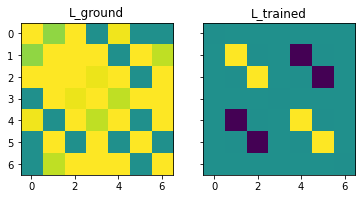

In [24]:
vmin = -0.5
vmax = 0.5
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(L_ground/np.trace(L_ground)*N, vmin = vmin, vmax = vmax)
ax1.set_title('L_ground')
ax2.imshow(res["L"], vmin = vmin, vmax = vmax)
ax2.set_title('L_trained')
plt.show()

I'm not able to retrieve the Laplacian, learned Laplacian is actually too sparse!!

In [25]:
np.trace(res["L"]) #trace is ok

7.0000000004205525

In [35]:
res["L"]@np.ones([N,1]) # eigenvector enforced

array([[ 0.],
       [ 0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

I see a problem, when asking for $\text{tr}(L)=N$ we are not ensuring that it is a valid Standard Laplacian as $L_{ii}\neq 1$. The algorithm isn't even stable for the loss function without regularizers

In [28]:
# checking if loss function is 0 for ground data
np.linalg.norm(X-lh.D(L_ground,tau_ground)@H_ground,'fro')**2
# yes it is and to good precision there is not a lot of roundoff errors

9.215093301406828e-31

In [26]:
res = lh.learn_heat(X,L0=L_ground,H0=H_ground,tau0=tau_ground,alpha=0,beta=0)

Learning progress:   0%|          | 0/100 [00:00<?, ?it/s]

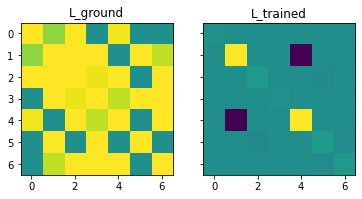

This should not be happening 💀


In [33]:
vmin = -0.5
vmax = 0.5
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(L_ground/np.trace(L_ground)*N, vmin = vmin, vmax = vmax)
ax1.set_title('L_ground')
ax2.imshow(res["L"], vmin = vmin, vmax = vmax)
ax2.set_title('L_trained')
plt.show()
print(emoji.emojize('This should not be happening :skull:'))


Last try, feeding all correctly except $\tau$

In [34]:
res = lh.learn_heat(X,L0=L_ground,H0=H_ground,tau0=[1,2],alpha=0.1,beta=0.05)

Learning progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
tau_ground

[2.5, 4]

In [38]:
res["tau"]

array([0.     , 1.48581])

Suppose we just use one diffusion rate and one signal, and that we lock in the Laplacian, how can the algorithm distinguish from

$H_0$ and $\tau=1$

between $e^{-0.5 L} H_0$ and $\tau=0.5$
this is trivial if you diagonalize

In [57]:
from scipy.linalg import expm

In [58]:
lhs = expm(-0.5*L_ground)@(expm(-0.5*L_ground)@H_ground[0:7,0])
rhs = expm(-L_ground)@H_ground[0:7,0]
np.linalg.norm(lhs-rhs)

2.1000903724951387e-16